In [97]:
library(devtools)
load_all()

ℹ Loading ghostbasil


In [169]:
generate.data <- function(n, p, seed, s)
{
    set.seed(seed)
    X <- matrix(rnorm(n * p), n, p)
    y <- X %*% rnorm(p) + rnorm(n)
    Sigma <- t(X) %*% X / n
    Sigma <- (1-s) * Sigma
    diag(Sigma) <- diag(Sigma) + s
    r <- t(X) %*% y / n
    list(Sigma=Sigma, r=r)
}

generate.data.block <- function(n, p, L, seed=0, s=0)
{
    data <- lapply(1:L, function(l) generate.data(n, p, seed + l - 1, s))
    mat.list <- lapply(1:L, function(l) data[[l]]$Sigma)
    r <- as.numeric(sapply(1:L, function(l) data[[l]]$r))
    A <- BlockMatrix(mat.list)
    A.dense <- A$to_dense()
    list(
        A=A,
        A.dense=A.dense,
        r=r
    )
}

In [182]:
n <- 5
p <- 100
L <- 2
seed <- 39
s <- 0

data <- generate.data.block(n, p, L, seed, s)
A.bm <- data$A
A.dm <- data$A.dense
r <- data$r

In [183]:
alpha <- 1

In [217]:
out <- ghostbasil(A.dm, r, alpha=alpha)
lmdas <- out$lmdas[1:length(out$lmdas)-1]
out <- ghostbasil(A.dm, r, alpha=alpha, user.lambdas=lmdas)

In [218]:
out.par <- ghostbasil(A.bm, r, alpha=alpha, n.threads=1, user.lambdas=lmdas)

In [219]:
out$checkpoint

$strong_set
 [1] 120 169 191  97 156 199  15  27  31  50  85 160   7  52 178  73   9  91   1
[20]  39  64  94

$strong_order
 [1] 18 12 16  6  7  8 19  9 13 20 15 10 17 21  3  0  4 11  1 14  2  5

$strong_beta
 [1]  3.8934052  2.3959943  0.0000000  4.3787984  0.0000000  1.5880274
 [7]  0.0000000  0.0000000 -4.5342442  0.3080982  0.0000000 -1.0140104
[13] -1.6064466  0.0000000 -1.5398737  0.0000000  0.0000000  0.0000000
[19]  0.0000000  0.0000000 -0.1604556  0.0000000

$strong_grad
 [1]  0.14514342  0.14514387 -0.13497707  0.14514353 -0.14411922  0.14514353
 [7] -0.11206887  0.09828478 -0.14528287  0.14506954  0.09676252 -0.14514395
[13] -0.14485386  0.12442478 -0.14514340 -0.12103998  0.13969836 -0.13689752
[19]  0.14450623 -0.14232493 -0.14512444 -0.14071290

$strong_A_diag
 [1] 2.3814926 2.2062336 1.8491488 2.2548112 2.0450302 2.4391083 1.1174109
 [8] 1.0569298 1.3419866 2.6027404 1.2190031 1.5306953 1.9688505 1.5372881
[15] 1.5347542 0.7580726 0.7865791 0.6721966 0.6468657 1.1257599 1.2095435
[22] 1.5716589

$active_set
 [1]  0  1  3  5 10  8  6 11 12 14  4  9 18 20

$active_order
 [1] 12  8  6  5 11 13  4  2  0 10  7  1  9  3

$active_set_ordered
 [1]   1   7  15  31  50  64  85  97 120 156 160 169 178 199

$is_active
 [1] 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0

$grad
  [1]  0.0230517031  0.1445062323 -0.0675998964 -0.0156365163 -0.0820552967
  [6] -0.0980299240 -0.0833607986 -0.1448538629 -0.0602465362  0.1396983581
 [11]  0.0647438506  0.1005796501  0.0923381744  0.0186620689 -0.0450047984
 [16] -0.1120688703  0.1261727093  0.0885778323  0.1187449310  0.0855483343
 [21]  0.0151045308  0.0068818431 -0.1064077311 -0.0226057250  0.0909671967
 [26] -0.0554743606 -0.0428782605  0.0982847795  0.1030636982 -0.0694537616
 [31] -0.1196474914 -0.1452828674 -0.0428330821 -0.0214043352 -0.0586705163
 [36]  0.0331454700 -0.0862355263  0.0194562164 -0.0372383145 -0.1423249342
 [41] -0.0014728497  0.1255798708  0.0860803831  0.0019746333 -0.0227130595
 [46] -0.0759187832  0.0776875093  0.1090327430  0.0949935289  0.0706468245
 [51]  0.1450695445  0.0219370596  0.1244247774 -0.1197207576 -0.0450887931
 [56] -0.1032045197 -0.0090356772 -0.0618483397 -0.0859541894  0.0606506929
 [61]  0.0171687047  0.0105487362  0.0005129944  0.0983538925 -0.1451244408
 [66]  0.1251954056  0.0743621894  0.0471870615  0.0528120105 -0.0327952514
 [71] -0.0038707932 -0.0949640913  0.0735570278 -0.1210399783 -0.0667754890
 [76] -0.0378589897 -0.0243903153  0.0394537047 -0.1020675635 -0.0623512329
 [81]  0.1247140908  0.0982239649 -0.0942881124  0.0995012428 -0.0138717914
 [86]  0.0967625233 -0.0135948220 -0.0044051014 -0.0308829294 -0.1112403792
 [91] -0.0161260534 -0.1368975162  0.0576298098  0.1316764592 -0.1407128952
 [96]  0.0975256077 -0.0970902950  0.1451435271  0.0377633769 -0.0921760570
[101] -0.0017707277 -0.0144370681 -0.0630891580  0.1001881903 -0.0433893650
[106]  0.0794590726  0.0815676303 -0.0582978694 -0.0088021937 -0.0750516088
[111] -0.0217957823  0.0303389625  0.0662170400 -0.0267028529 -0.0124500160
[116] -0.0515597603 -0.1261150077  0.0741853592 -0.0151897707  0.0058977628
[121]  0.1451434180  0.0204699656  0.1178045523  0.0389995372  0.0186046840
[126] -0.0099576129  0.0496138511 -0.0233137355 -0.0214739447  0.0190299943
[131] -0.0259129260 -0.0847720450 -0.0338430628 -0.1028225724 -0.0589578013
[136]  0.0001228972 -0.0037682018  0.1058576421  0.0630103700  0.0324896379
[141]  0.0537952943  0.0131781627 -0.0093211040 -0.0815762580  0.0154963207
[146] -0.0480758441 -0.0661927951  0.0302936227 -0.0861985546 -0.0476726124
[151]  0.0204722932 -0.0773094035 -0.0371848381 -0.0061037290  0.0348267778
[156] -0.0151610344 -0.1441192246  0.0253231398 -0.0792955195  0.0395790293
[161] -0.1451439540 -0.0712944168 -0.0307968947  0.0112787524 -0.0506000364
[166] -0.0226582421 -0.0485453697 -0.0435982065  0.0248657487  0.1451438709
[171] -0.0188261295 -0.0968262057 -0.0262749692  0.0055520132 -0.0688449634
[176]  0.1092623141  0.0527572813 -0.00584

In [220]:
# strong set
sort(c(out.par$checkpoint[[1]]$strong_set, out.par$checkpoint[[2]]$strong_set + 100))
sort(out$checkpoint$strong_set)

# grad
(out$checkpoint$grad - c(out.par$checkpoint[[1]]$grad, out.par$checkpoint[[2]]$grad))[100:200]

# rsq
out$checkpoint$rsq
out.par$checkpoint[[1]]$rsq + out.par$checkpoint[[2]]$rsq

[1]   1   7   9  15  27  31  39  50  52  64  73  85  91  94  97 120 156 160 169
[20] 178 191 199

[1]   1   7   9  15  27  31  39  50  52  64  73  85  91  94  97 120 156 160 169
[20] 178 191 199

[1]  8.881784e-16  8.045058e-05 -1.063544e-04 -2.465068e-05  2.886692e-05
  [6]  8.609381e-05  4.725761e-05  4.155894e-05  2.402456e-05  5.347256e-05
 [11]  3.811405e-06  5.561646e-05 -6.690416e-05 -6.987205e-05 -1.873460e-05
 [16] -3.203269e-05 -6.861949e-06  1.991533e-05 -3.623258e-05 -1.525441e-05
 [21]  1.634944e-06 -9.484746e-05  2.025110e-06  3.719063e-05 -1.571080e-05
 [26]  4.769603e-05 -2.378531e-05 -6.414776e-06 -2.346816e-05 -1.787687e-05
 [31]  1.008866e-04 -1.225089e-05 -2.519792e-06 -1.405739e-04  6.688332e-05
 [36]  4.859776e-05  2.909187e-05  1.591589e-04 -3.209957e-05 -8.445388e-05
 [41]  1.041707e-04 -4.377786e-05 -7.950416e-05 -9.766809e-05 -1.073528e-04
 [46] -4.166720e-05  4.411816e-05 -6.196455e-05  1.600405e-05 -3.066043e-05
 [51] -1.072360e-04 -6.961481e-06  4.554793e-05 -1.166288e-04 -5.383624e-05
 [56]  5.196198e-05 -6.395897e-05  1.467504e-04 -2.270469e-05 -6.506464e-05
 [61] -1.193851e-04 -7.494269e-05 -7.224935e-05  2.199204e-05  1.001097e-04
 [66]  8.472952e-05  1.192250e-04 -8.344540e-05  2.031631e-05 -7.089032e-05
 [71]  1.030104e-04 -7.939956e-05 -6.789196e-05  1.073031e-04 -1.006673e-04
 [76] -6.640281e-05 -5.391895e-05  1.066589e-05  2.818388e-05 -2.455944e-05
 [81]  8.510097e-07  6.763132e-05  1.646360e-05  1.593580e-06 -4.034126e-05
 [86]  1.663135e-05 -1.556365e-05 -1.357177e-04 -1.013102e-04 -1.036407e-05
 [91]  3.052003e-05 -5.543699e-05  1.983534e-05 -1.173322e-04  5.616874e-06
 [96]  1.280076e-05  1.110502e-04 -5.942686e-05  3.851084e-05 -4.613797e-05
[101]  0.000000e+00

[1] 230.4108

[1] 230.4108

In [222]:
(out$rsqs-out.par$rsqs)
sum(out$lmdas != out.par$lmdas)
sum(out$rsqs != out.par$rsqs)
sum(out$betas != out.par$betas)

[1]  0.000000e+00  1.741263e-10  3.477246e-10  5.656358e-10  7.641871e-10
 [6]  9.450996e-10  1.109940e-09 -1.884609e-07  1.562274e-09  1.801684e-09
[11]  2.019826e-09 -1.112209e-07 -6.842731e-08 -6.189107e-08 -5.593560e-08
[16]  1.395506e-07  2.032781e-07  7.860695e-07  5.097852e-07  4.649781e-07
[21]  4.241600e-07  9.980579e-07  9.094592e-07  5.456459e-06 -8.180818e-08
[26] -9.922577e-08 -9.652079e-08 -9.030304e-08 -8.178240e-08 -7.401930e-08
[31] -6.694585e-08 -6.050079e-08 -5.462828e-08 -5.116239e-08 -2.348039e-07
[36] -1.441589e-07 -2.678026e-07 -1.838164e-07 -1.567079e-07 -1.422857e-07
[41] -1.291480e-07 -1.046822e-07 -1.672947e-07 -7.622275e-08 -3.765386e-08
[46] -7.678360e-07 -7.827375e-07 -7.066550e-07 -7.377661e-07 -7.225491e-07
[51] -6.834792e-07 -6.346095e-07 -5.835810e-07 -5.339878e-07 -4.873400e-07
[56] -4.441511e-07 -4.044782e-07 -3.681796e-07 -3.350355e-07 -3.048029e-07
[61] -2.617268e-07 -2.344308e-07 -2.122959e-07 -1.927533e-07 -1.750898e-07
[66] -1.590281e-07 -1.444006e-07 -1.310743e-07 -1.189322e-07 -1.078688e-07
[71] -9.778828e-08 -8.188634e-08 -7.233954e-08 -6.494652e-08 -5.855524e-08
[76] -5.282288e-08 -4.762385e-08 -4.289304e-08 -3.858419e-08 -3.465857e-08
[81] -3.108181e-08 -4.186164e-08 -1.194473e-08 -7.909939e-09 -6.437827e-09
[86] -5.338736e-09 -4.370336e-09 -3.483739e-09 -2.684235e-09 -1.947874e-09
[91] -1.276937e-09 -4.947036e-09 -4.175536e-09 -3.306252e-09 -2.520601e-09
[96] -1.798753e-09 -1.141064e-09 -5.464380e-10  0.000000e+00

[1] 0

[1] 97

[1] 753

In [223]:
obj <- function(A, r, beta, lmda, penalty=rep(1, length(r)), alpha=1)
{
    objective_dense__(A, r, penalty, alpha, lmda, beta)
}

[1] 46

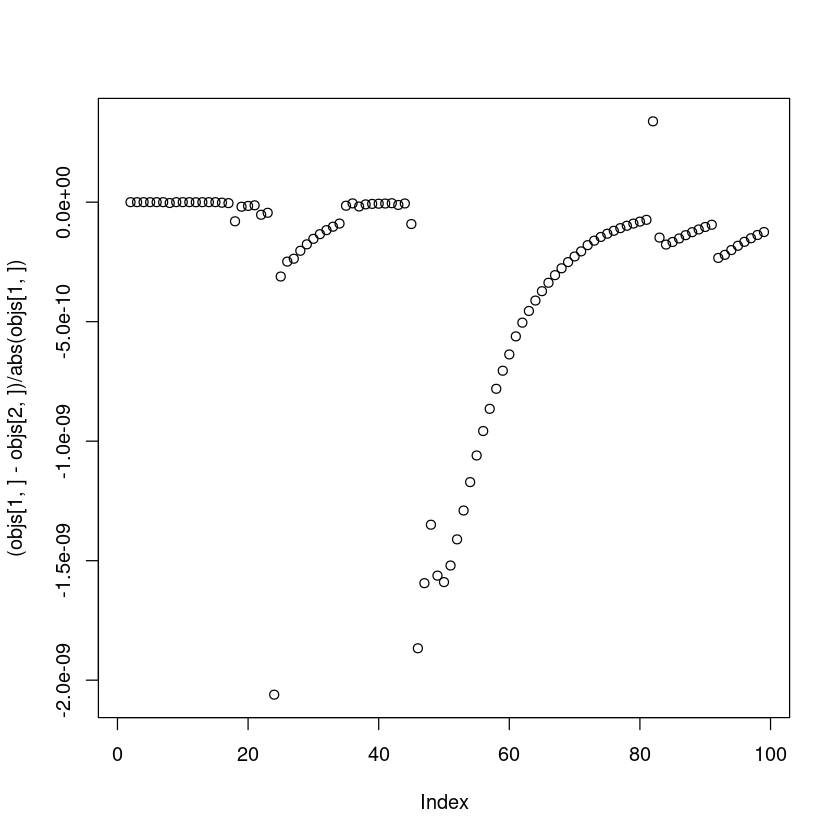

In [224]:
objs <- sapply(1:length(out$lmdas), 
    function(i) {
        c(obj(A.dm, r, out$beta[, i], out$lmdas[i])$objective,
          obj(A.dm, r, out.par$beta[, i], out.par$lmdas[i])$objective)
    })
colors <- c('black', 'red')[(objs[1,] < objs[2,]) + 1]
#plot(objs[1,], objs[2,], col=colors)
plot((objs[1,]-objs[2,]) / abs(objs[1,]))
which(objs[1,]-objs[2,] == min(objs[1,]-objs[2,]))